In [ ]:
!unzip /content/archive.zip

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

In [ ]:
data_dir = '/content'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')


class RandomAxisStretch:
    """Растягивает изображение случайно по одной или обеим осям"""
    def __init__(self, scale_x_range=(0.8, 1.2), scale_y_range=(0.8, 1.2)):
        self.scale_x_range = scale_x_range
        self.scale_y_range = scale_y_range

    def __call__(self, img):
        scale_x = np.random.uniform(*self.scale_x_range)
        scale_y = np.random.uniform(*self.scale_y_range)
        w, h = img.size
        new_w, new_h = int(w * scale_x), int(h * scale_y)
        img = F.resize(img, (new_h, new_w), interpolation=F.InterpolationMode.BILINEAR)
        return F.center_crop(img, (h, w))

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # до ±10% сдвиги
    RandomAxisStretch(scale_x_range=(0.85, 1.15), scale_y_range=(0.85, 1.15)),  # растяжение по x/y
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])



test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

class_names = train_dataset.classes
print("Классы:", class_names)

Классы: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)


class ConvModel(nn.Module):
    def __init__(self, in_channels, out_channels, h, w, n_labels):
        super().__init__()
        # TODO: поэкспериментировать с архитектурой
        self.conv = nn.Sequential(
            ConvBlock(in_channels, 8),
            ConvBlock(8, 16),
            ConvBlock(16, 32),
            ConvBlock(32, 64),
            ConvBlock(64, 128),
            ConvBlock(128, 256)
        )

        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, h, w)
            dummy_out = self.conv(dummy)
            flattened_size = dummy_out.view(1, -1).shape[1]

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, n_labels)
        )

    def forward(self, x):
        return self.classifier(self.conv(x))

Epoch 1/40: 100%|██████████| 449/449 [00:31<00:00, 14.06it/s]


Epoch [1/40], Loss: 1.8098, Accuracy: 25.64%


Epoch 2/40: 100%|██████████| 449/449 [00:32<00:00, 13.87it/s]


Epoch [2/40], Loss: 1.7505, Accuracy: 28.56%


Epoch 3/40: 100%|██████████| 449/449 [00:33<00:00, 13.60it/s]


Epoch [3/40], Loss: 1.6907, Accuracy: 32.74%


Epoch 4/40: 100%|██████████| 449/449 [00:32<00:00, 13.92it/s]


Epoch [4/40], Loss: 1.6402, Accuracy: 35.34%


Epoch 5/40: 100%|██████████| 449/449 [00:31<00:00, 14.33it/s]


Epoch [5/40], Loss: 1.5951, Accuracy: 37.33%


Epoch 6/40: 100%|██████████| 449/449 [00:32<00:00, 13.81it/s]


Epoch [6/40], Loss: 1.5581, Accuracy: 39.03%


Epoch 7/40: 100%|██████████| 449/449 [00:31<00:00, 14.13it/s]


Epoch [7/40], Loss: 1.5170, Accuracy: 40.81%


Epoch 8/40: 100%|██████████| 449/449 [00:32<00:00, 13.65it/s]


Epoch [8/40], Loss: 1.4747, Accuracy: 42.66%


Epoch 9/40: 100%|██████████| 449/449 [00:31<00:00, 14.14it/s]


Epoch [9/40], Loss: 1.4371, Accuracy: 43.86%


Epoch 10/40: 100%|██████████| 449/449 [00:32<00:00, 13.62it/s]


Epoch [10/40], Loss: 1.4087, Accuracy: 45.39%


Epoch 11/40: 100%|██████████| 449/449 [00:31<00:00, 14.21it/s]


Epoch [11/40], Loss: 1.3824, Accuracy: 46.58%


Epoch 12/40: 100%|██████████| 449/449 [00:32<00:00, 13.81it/s]


Epoch [12/40], Loss: 1.3569, Accuracy: 47.36%


Epoch 13/40: 100%|██████████| 449/449 [00:31<00:00, 14.38it/s]


Epoch [13/40], Loss: 1.3378, Accuracy: 48.59%


Epoch 14/40: 100%|██████████| 449/449 [00:32<00:00, 13.63it/s]


Epoch [14/40], Loss: 1.3213, Accuracy: 49.08%


Epoch 15/40: 100%|██████████| 449/449 [00:31<00:00, 14.25it/s]


Epoch [15/40], Loss: 1.3069, Accuracy: 49.95%


Epoch 16/40: 100%|██████████| 449/449 [00:32<00:00, 13.95it/s]


Epoch [16/40], Loss: 1.2971, Accuracy: 50.51%


Epoch 17/40: 100%|██████████| 449/449 [00:31<00:00, 14.42it/s]


Epoch [17/40], Loss: 1.2833, Accuracy: 50.99%


Epoch 18/40: 100%|██████████| 449/449 [00:31<00:00, 14.37it/s]


Epoch [18/40], Loss: 1.2712, Accuracy: 51.61%


Epoch 19/40: 100%|██████████| 449/449 [00:31<00:00, 14.26it/s]


Epoch [19/40], Loss: 1.2690, Accuracy: 51.06%


Epoch 20/40: 100%|██████████| 449/449 [00:32<00:00, 13.64it/s]


Epoch [20/40], Loss: 1.2540, Accuracy: 52.12%


Epoch 21/40: 100%|██████████| 449/449 [00:33<00:00, 13.60it/s]


Epoch [21/40], Loss: 1.2477, Accuracy: 52.33%


Epoch 22/40: 100%|██████████| 449/449 [00:31<00:00, 14.26it/s]


Epoch [22/40], Loss: 1.2449, Accuracy: 52.51%


Epoch 23/40: 100%|██████████| 449/449 [00:31<00:00, 14.06it/s]


Epoch [23/40], Loss: 1.2436, Accuracy: 53.07%


Epoch 24/40: 100%|██████████| 449/449 [00:31<00:00, 14.31it/s]


Epoch [24/40], Loss: 1.2371, Accuracy: 53.06%


Epoch 25/40: 100%|██████████| 449/449 [00:33<00:00, 13.54it/s]


Epoch [25/40], Loss: 1.2313, Accuracy: 53.04%


Epoch 26/40: 100%|██████████| 449/449 [00:32<00:00, 13.97it/s]


Epoch [26/40], Loss: 1.2229, Accuracy: 53.82%


Epoch 27/40: 100%|██████████| 449/449 [00:31<00:00, 14.10it/s]


Epoch [27/40], Loss: 1.2191, Accuracy: 53.47%


Epoch 28/40: 100%|██████████| 449/449 [00:32<00:00, 13.92it/s]


Epoch [28/40], Loss: 1.2120, Accuracy: 54.17%


Epoch 29/40: 100%|██████████| 449/449 [00:31<00:00, 14.26it/s]


Epoch [29/40], Loss: 1.2094, Accuracy: 54.20%


Epoch 30/40: 100%|██████████| 449/449 [00:32<00:00, 13.88it/s]


Epoch [30/40], Loss: 1.2067, Accuracy: 53.85%


Epoch 31/40: 100%|██████████| 449/449 [00:32<00:00, 13.95it/s]


Epoch [31/40], Loss: 1.1983, Accuracy: 54.66%


Epoch 32/40: 100%|██████████| 449/449 [00:32<00:00, 13.73it/s]


Epoch [32/40], Loss: 1.1971, Accuracy: 54.56%


Epoch 33/40: 100%|██████████| 449/449 [00:32<00:00, 13.92it/s]


Epoch [33/40], Loss: 1.1930, Accuracy: 54.98%


Epoch 34/40: 100%|██████████| 449/449 [00:31<00:00, 14.14it/s]


Epoch [34/40], Loss: 1.1934, Accuracy: 54.68%


Epoch 35/40: 100%|██████████| 449/449 [00:32<00:00, 13.88it/s]


Epoch [35/40], Loss: 1.1826, Accuracy: 55.30%


Epoch 36/40: 100%|██████████| 449/449 [00:32<00:00, 13.91it/s]


Epoch [36/40], Loss: 1.1856, Accuracy: 55.39%


Epoch 37/40: 100%|██████████| 449/449 [00:32<00:00, 13.85it/s]


Epoch [37/40], Loss: 1.1798, Accuracy: 55.28%


Epoch 38/40: 100%|██████████| 449/449 [00:30<00:00, 14.52it/s]


Epoch [38/40], Loss: 1.1765, Accuracy: 55.24%


Epoch 39/40: 100%|██████████| 449/449 [00:31<00:00, 14.07it/s]


Epoch [39/40], Loss: 1.1718, Accuracy: 55.27%


Epoch 40/40: 100%|██████████| 449/449 [00:31<00:00, 14.34it/s]


Epoch [40/40], Loss: 1.1796, Accuracy: 55.15%


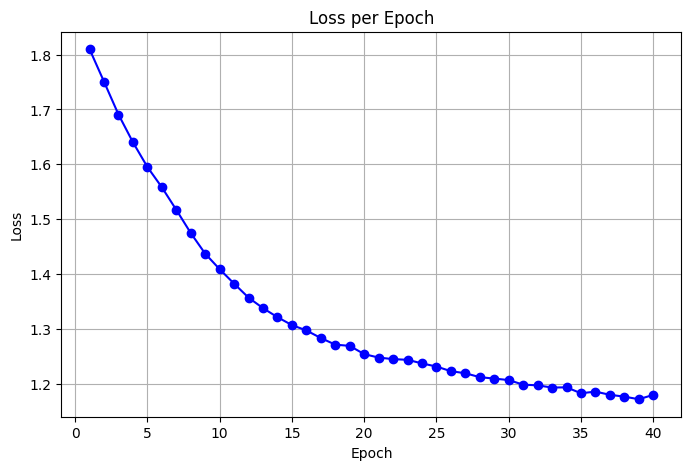

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvModel(1, 64, 48, 48, 7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

import matplotlib.pyplot as plt
from tqdm import tqdm

def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    epoch_losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        avg_loss = running_loss / len(train_loader)
        epoch_losses.append(avg_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {100.*correct/total:.2f}%")

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs + 1), epoch_losses, marker='o', color='b')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

train_model(model, train_loader, criterion, optimizer, epochs=40)

100%|██████████| 113/113 [00:04<00:00, 23.02it/s]


Classification Report:
              precision    recall  f1-score   support

       angry       0.45      0.45      0.45       958
   disgusted       0.60      0.16      0.26       111
     fearful       0.38      0.25      0.30      1024
       happy       0.72      0.84      0.78      1774
     neutral       0.45      0.67      0.54      1233
         sad       0.46      0.28      0.35      1247
   surprised       0.69      0.73      0.71       831

    accuracy                           0.55      7178
   macro avg       0.54      0.48      0.48      7178
weighted avg       0.54      0.55      0.53      7178



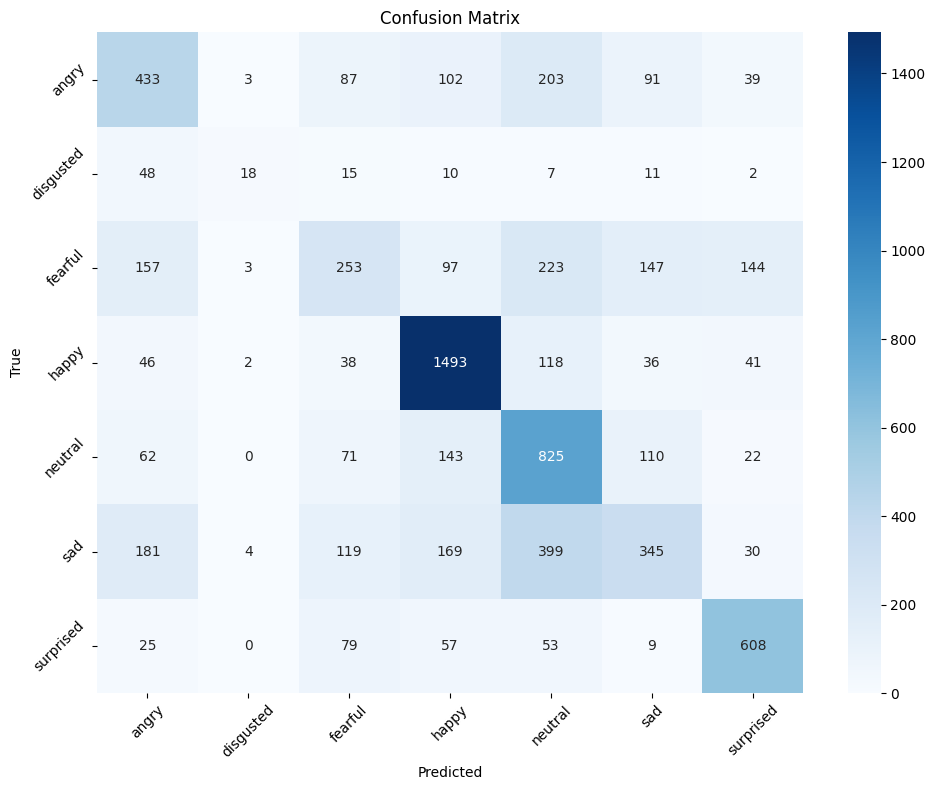

In [ ]:
# TODO: нарисовать примеры предсказания с классами
def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Убедись, что модель возвращает (features, outputs)
            _, preds = outputs.max(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

evaluate_model(model, test_loader, class_names)